Finetuning a pretrained network
=================

We can take a network which was trained on the ImageNet dataset and adapt it to our own image classification problem. This can be a useful technique when training data is too limited to train a model from scratch.

Here we try to classify images as either pancakes or waffles.

In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

%matplotlib inline
import matplotlib.pyplot as plt

import skimage.transform
import sklearn.cross_validation
import pickle
import os

import scipy.ndimage.interpolation as sn
from scipy.misc import imresize

Using gpu device 0: GeForce GTX TITAN Black (CNMeM is disabled, cuDNN 5105)


In [2]:
# Seed for reproducibility
np.random.seed(42)

In [3]:
CLASSES = range(25)
LABELS = {cls: i for i, cls in enumerate(CLASSES)}

In [4]:
# Model definition for VGG-16, 16-layer model from the paper:
# "Very Deep Convolutional Networks for Large-Scale Image Recognition"
# Original source: https://gist.github.com/ksimonyan/211839e770f7b538e2d8

# More pretrained models are available from
# https://github.com/Lasagne/Recipes/blob/master/modelzoo/
from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax
from lasagne.utils import floatX

def build_model():
    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1)
    net['pool3'] = PoolLayer(net['conv3_3'], 2)
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1)
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1)
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc7'] = DenseLayer(net['fc6'], num_units=4096)
    net['fc8'] = DenseLayer(net['fc7'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)

    return net

In [5]:
# Load model weights and metadata
d = pickle.load(open('vgg16.pkl'))

In [6]:
# Build the network and fill with pretrained weights
net = build_model()
lasagne.layers.set_all_param_values(net['prob'], d['param values'])

In [7]:
# The network expects input in a particular format and size.
# We define a preprocessing function to load a file and apply the necessary transformations
IMAGE_MEAN = d['mean value'][:, np.newaxis, np.newaxis]

def prep_image(fn, ext='jpg'):
    im = plt.imread(fn, ext)

    # Resize so smallest dim = 256, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (256, w*256/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*256/w, 256), preserve_range=True)

    # Central crop to 224x224
    h, w, _ = im.shape
    im = im[h//2-112:h//2+112, w//2-112:w//2+112]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # discard alpha channel if present
    im = im[:3]

    # Convert to BGR
    im = im[::-1, :, :]

    im = im - IMAGE_MEAN
    return rawim, floatX(im[np.newaxis])

def deprocess(im):
    im = im[::-1, :, :]
    im = np.swapaxes(np.swapaxes(im, 0, 1), 1, 2)
    im = (im - im.min())
    im = im / im.max()
    return im

In [8]:
#load real images
#for real images; from brenton
classes = ['highland_6539_self_stick_notes', 'dr_browns_bottle_brush',
'paper_mate_12_count_mirado_black_warrior', 'first_years_take_and_toss_straw_cup',
'safety_works_safety_glasses', 'mark_twain_huckleberry_finn',
'champion_copper_plus_spark_plug', 'laugh_out_loud_joke_book',
'mead_index_cards', 'elmers_washable_no_run_school_glue',
'crayola_64_ct', 'kyjen_squeakin_eggs_plush_puppies',
'kong_duck_dog_toy', 'munchkin_white_hot_duck_bath_toy',
'oreo_mega_stuf', 'kong_sitting_frog_dog_toy', 'kong_air_dog_squeakair_tennis_ball',
'stanley_66_052', 'rolodex_jumbo_pencil_cup', 'mommys_helper_outlet_plugs', 'cheezit_big_original', 
'feline_greenies_dental_treats', 'genuine_joe_plastic_stir_sticks',
'sharpie_accent_tank_style_highlighters', 'expo_dry_erase_board_eraser']
LABELS_real = {cls: i for i, cls in enumerate(classes)}

# #load real images

# X_real = []
# y_real = []
# directory='/home/kevin/Documents/ARC/ARC2015realimages/'
# for fn in os.listdir(directory):
#     if fn[-3:]!='png':
#         continue
#     cls=fn.partition('-image')[0]
#     cls=np.int32(LABELS_real[cls])
#     #print cls
#     if cls in [13,15]: #bad image categories
#         continue
#     _, im = prep_image(directory+fn)
#     X_real.append(im)
#     y_real.append(cls) 
# X_real = np.concatenate(X_real)+13.7 #manually computed mean...
# y_real = np.array(y_real).astype('int32')       

#get real images that brenton himself took
X_real = []
y_real = []
directory='/home/kevin/Documents/ARC/images/real/'
for subdir in os.walk(directory): #first get the folders, which contain different classes of images
    dir_=subdir[0]
    #get the class label
    cls=dir_.partition('real/')[-1]
    if not cls: #if it's empty (the root directory)
        continue
    cls=cls[:-1] #strip away the last number, which denote multiple folders of the same class
    cls=np.int32(LABELS_real[cls])
    
    for imfile in os.listdir(dir_): #now loop through all the images in that folder's class
        if imfile[-3:]!='png': #if not an image file
            continue
        _,im=prep_image(dir_+'/'+imfile)
        X_real.append(im)
        y_real.append(cls)

X_real = np.concatenate(X_real)
y_real = np.array(y_real).astype('int32') 
chosen_classes=np.unique(y_real) #if you want to restrict the training data
LABELS_reduced={cls: i for i, cls in enumerate(chosen_classes)} #map to the smallest range of values, starting at 0


In [9]:
# Load and preprocess the entire dataset into numpy arrays
X = []
y = []
directory='/home/kevin/Documents/ARC/images/output2/'
for fn in os.listdir(directory):
    cls=np.int32(fn.partition('_')[0]) #file names of the form '2_123.png', class 2, image number 123
    #if cls in [13,15]: #bad image categories; 8 is not in the "real" dataset
    if cls not in chosen_classes:
        continue
    _, im = prep_image(directory+fn)
    X.append(im)
    y.append(cls) 
X = np.concatenate(X)
y = np.array(y).astype('int32')            

In [10]:
#map to smallest range of consecutive values, starting at 0
y=np.array([LABELS_reduced[i] for i in y]).astype('int32')
y_real=np.array([LABELS_reduced[i] for i in y_real]).astype('int32')

In [11]:
def random_shift_scale(X_stack,pixel_translate_max=40,border_max=50):
    #given input stack of images (4D tensor), generate a random xy shift from [0,pixel_translate_max]^2
    #and randomly dilate/shrink by removing/padding by border_max
    X_aug=np.zeros_like(X_stack)
    
    for i in xrange(len(X_stack)):
        im=X_stack[i]
        
        border=np.random.randint(1,border_max)
        
        shrink=np.random.rand()>.5

        for j in xrange(3):
            #if zooming in, remove border then resize; if zooming out, pad then resize
            if shrink:
                IM=im[j][border:-border,border:-border]
            else:
                IM=np.pad(im[j],((border,border),(border,border)),'edge')
                
            #print IM.shape
            X_aug[i,j]=imresize(IM,(224,224))
        IM=X_aug[i]
        #random translation
        x_trans=np.random.randint(-pixel_translate_max,pixel_translate_max)
        y_trans=np.random.randint(-pixel_translate_max,pixel_translate_max)
        IM=np.roll(IM,x_trans,1)
        X_aug[i]=np.roll(IM,y_trans,2)*(np.random.rand()*.5*2*1.5+.5)+np.random.randn()*20*2*2
    
    return X_aug

In [12]:
##X= random_shift_scale(X,100,100)
X=random_shift_scale(X,80,100)
#X= random_shift_scale(X,80,50)

In [13]:
# Split into train, validation and test sets
# train_ix, test_ix = sklearn.cross_validation.train_test_split(range(len(y)))
# train_ix, val_ix = sklearn.cross_validation.train_test_split(range(len(train_ix)))

# X_tr = X[train_ix]
# y_tr = y[train_ix]

# X_val = X[val_ix]
# y_val = y[val_ix]

# X_te = X[test_ix]
# y_te = y[test_ix]

#or use real data
# X_tr=X
# y_tr=y
# X_val=X_real
# y_val=y_real

#or combine some real data into training set
#borrow is the indices of the real dataset to borrow into the training set
#keep is kept in the test set
keep,borrow=sklearn.cross_validation.train_test_split(range(len(y_real)),test_size=.2)
downsamp=3 #how much to downsample the original train set so that it doesn't overwhelm the borrowed data
X_tr=X_real[borrow]#np.vstack([X[0:-1:downsamp],X_real[borrow]])
y_tr=y_real[borrow]#np.concatenate([y[0:-1:downsamp],y_real[borrow]])
X_val=X_real[keep]
y_val=y_real[keep]

In [14]:
# We'll connect our output classifier to the last fully connected layer of the network
output_layer = DenseLayer(net['fc7'], num_units=len(chosen_classes), nonlinearity=softmax)


In [15]:
#freeze some parameters, if desired

# for layer in lasagne.layers.get_all_layers(output_layer):
#     if layer is not output_layer:
#         for param in layer.params:
#             layer.params[param].discard('trainable')


In [16]:
# Define loss function and metrics, and get an updates dictionary
X_sym = T.tensor4()
y_sym = T.ivector()

prediction = lasagne.layers.get_output(output_layer, X_sym)
loss = lasagne.objectives.categorical_crossentropy(prediction, y_sym)
loss = loss.mean()

acc = T.mean(T.eq(T.argmax(prediction, axis=1), y_sym),
                      dtype=theano.config.floatX)

params = lasagne.layers.get_all_params(output_layer, trainable=True)
updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=0.0001/2, momentum=0.9)

In [17]:
# Compile functions for training, validation and prediction
train_fn = theano.function([X_sym, y_sym], loss, updates=updates)
val_fn = theano.function([X_sym, y_sym], [loss, acc])
pred_fn = theano.function([X_sym], prediction)

In [18]:
# generator splitting an iterable into chunks of maximum length N
def batches(iterable, N):
    chunk = []
    for item in iterable:
        chunk.append(item)
        if len(chunk) == N:
            yield chunk
            chunk = []
    if chunk:
        yield chunk

In [19]:
# We need a fairly small batch size to fit a large network like this in GPU memory
BATCH_SIZE = 32

In [20]:
def train_batch():
    ix = range(len(y_tr))
    np.random.shuffle(ix)
    ix = ix[:BATCH_SIZE]
    return train_fn(X_tr[ix], y_tr[ix])

def val_batch():
    ix = range(len(y_val))
    np.random.shuffle(ix)
    ix = ix[:BATCH_SIZE]
    return val_fn(X_val[ix], y_val[ix])

In [21]:
from time import time
start=time()
for epoch in range(20):
    for batch in range(25):
        loss = train_batch()

    ix = range(len(y_val))
    np.random.shuffle(ix)

    loss_tot = 0.
    acc_tot = 0.
    for chunk in batches(ix, BATCH_SIZE):
        loss, acc = val_fn(X_val[chunk], y_val[chunk])
        loss_tot += loss * len(chunk)
        acc_tot += acc * len(chunk)

    loss_tot /= len(ix)
    acc_tot /= len(ix)
    print(epoch, loss_tot, acc_tot * 100,time()-start)

(0, 0.70047163224853248, 79.646017699115049, 57.49169707298279)
(1, 0.24944617236610009, 92.477876106194685, 115.17667603492737)
(2, 0.1924386013925603, 95.022123893805315, 172.95881509780884)
(3, 0.17592290657020249, 95.13274336283186, 232.46629214286804)
(4, 0.18060506735227805, 95.022123893805315, 293.142853975296)
(5, 0.16911061055364862, 95.13274336283186, 353.47619915008545)
(6, 0.16963885612456145, 95.13274336283186, 413.5951759815216)
(7, 0.16503117198899256, 95.243362831858406, 473.53027606010437)
(8, 0.15865722554529796, 95.464601769911511, 533.1512110233307)
(9, 0.15845699225906776, 95.575221238938056, 593.0241100788116)
(10, 0.15884810785012962, 95.353982300884951, 651.7863821983337)
(11, 0.1592075497126289, 95.353982300884951, 710.7193830013275)
(12, 0.15557245068680658, 95.464601769911511, 769.7283620834351)
(13, 0.15857241124705931, 95.575221238938056, 828.8550691604614)
(14, 0.15390015657232925, 95.464601769911511, 887.6823811531067)
(15, 0.15413475489095513, 95.4646017

In [22]:
loss_tot = 0.
acc_tot = 0.
ix = range(len(y_real))
for chunk in batches(ix, BATCH_SIZE):
    loss, acc = val_fn(X_real[chunk], y_real[chunk])
    loss_tot += loss * len(chunk)
    acc_tot += acc * len(chunk)

loss_tot /= len(ix)
acc_tot /= len(ix)
print loss_tot,acc_tot

0.122809380875 0.964601769912


In [23]:
#compute top-k accuracy
matches=list() #list of 0s and 1s to indicate whether there is a top k match
k=3
ix = range(len(y_real))
for chunk in batches(ix, BATCH_SIZE):
    p_y=pred_fn(X_real[chunk]).argsort()[:,-k:][:,::-1]
    for i in xrange(len(chunk)):
        matches.append(y_real[chunk][i] in p_y[i])
print np.mean(matches) 

0.99203539823


In [24]:
#confusion matrix
from sklearn.metrics import confusion_matrix

preds=list()
ix = range(len(y_real))
for chunk in batches(ix, BATCH_SIZE):
    p_y=pred_fn(X_real[chunk]).argmax(-1)
    for i in p_y:
        preds.append(i)
  

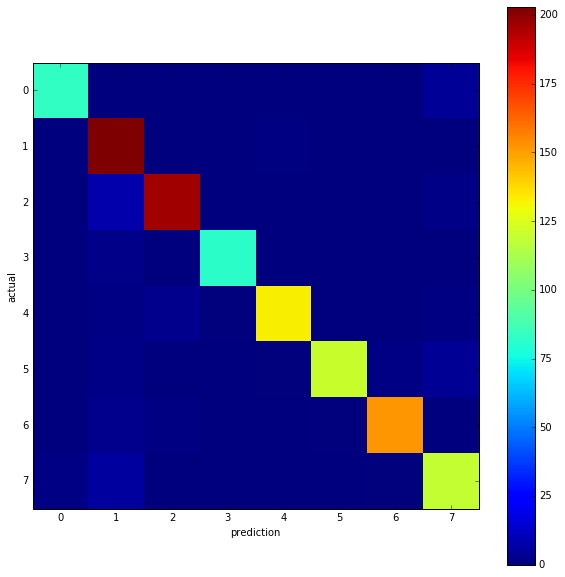

In [25]:
conf=confusion_matrix(y_real,preds,labels=range(len(chosen_classes)))    

plt.figure(figsize=(10,10))
plt.imshow(conf,interpolation='none')
plt.xlabel('prediction')
plt.ylabel('actual')
plt.colorbar()
plt.show()

#plt.hist(preds,25)

In [26]:
chosen_classes

array([ 1,  7,  9, 12, 16, 17, 18, 24], dtype=int32)

In [27]:
for i in xrange(25):
    print i,np.mean(np.array(preds)==i)

0 0.0752212389381
1 0.199115044248
2 0.176991150442
3 0.0725663716814
4 0.118584070796
5 0.107079646018
6 0.135398230088
7 0.115044247788
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0


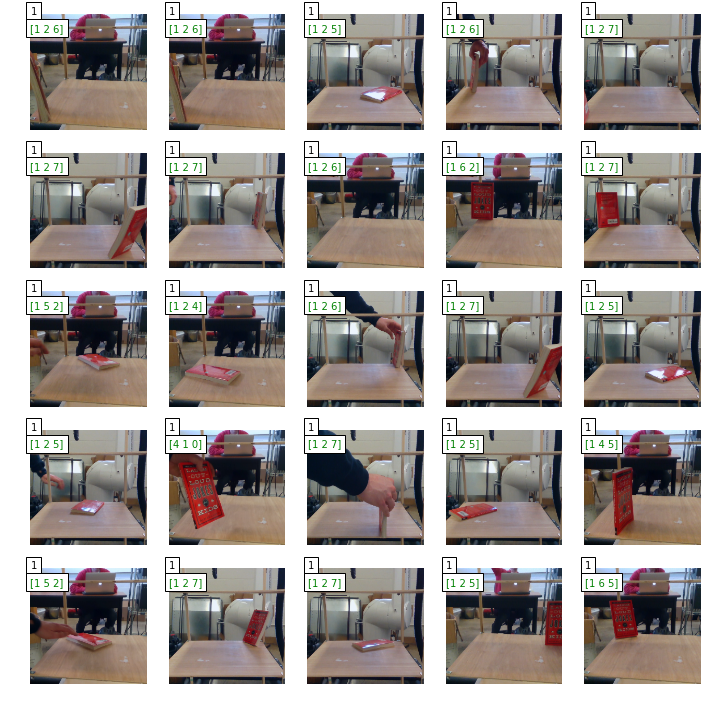

In [28]:
# Plot some results from the validation set
X_=X_real
y_=y_real

start=300
selected_range=np.arange(start,start+25)
#p_y = pred_fn(X_[selected_range]).argmax(-1)
k=3 #top k
p_y=pred_fn(X_[selected_range]).argsort()[:,-k:][:,::-1]

plt.figure(figsize=(12, 12))
count=0
for i in selected_range:
    plt.subplot(5, 5, count+1)
    plt.imshow(deprocess(X_[i]))
    true = y_[i]
    pred = p_y[count]
    color = 'green' if true in pred else 'red'
    plt.text(0, 0, true, color='black', bbox=dict(facecolor='white', alpha=1))
    plt.text(0, 32, pred, color=color, bbox=dict(facecolor='white', alpha=1))

    plt.axis('off')
    count+=1